1. Data Acquisition and Loading

In [1]:
import pandas as pd
import bz2

# I needed to handle the compressed format and understand the structure first
file_path = r'C:\Software Engineering\PLP S.E\PLP\Assignments\A.I for S.E baby\Week Three\amazon\train.ft.txt.bz2'

# I explored the file structure to understand the format
with bz2.open(file_path, 'rt', encoding='utf-8') as f:
    print("First 5 lines of the dataset:")
    for i in range(5):
        print(f"Line {i+1}: {f.readline().strip()}")

First 5 lines of the dataset:
Line 1: __label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^
Line 2: __label__2 The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every pe

2. Data Preprocessing and Cleaning

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# I discovered the data wasn't in standard CSV format, so I loaded it as a single column
df_train = pd.read_csv(file_path, compression='bz2', delimiter='\t', header=None)

# I needed to parse the FastText format: __label__[sentiment] [review_text]
df_train[0] = df_train[0].astype(str)

# I split the labels from the review text
df_train[['sentiment', 'review_text']] = df_train[0].str.split(' ', n=1, expand=True)

# I cleaned the sentiment labels by removing the '__label__' prefix
df_train['sentiment'] = df_train['sentiment'].str.replace('__label__', '', regex=False)

# I dropped the original column as it's no longer needed
df_train = df_train.drop(columns=[0])

print("Dataset shape:", df_train.shape)
print("\nDataset info:")
print(df_train.info())

Dataset shape: (3600000, 2)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600000 entries, 0 to 3599999
Data columns (total 2 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   sentiment    object
 1   review_text  object
dtypes: object(2)
memory usage: 54.9+ MB
None


3. Exploratory Data Analysis

Sentiment Distribution:
sentiment
2    1800000
1    1800000
Name: count, dtype: int64


C:\Users\Kingm\AppData\Local\Temp\ipykernel_10036\1572591334.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_train, x='sentiment', palette='viridis')


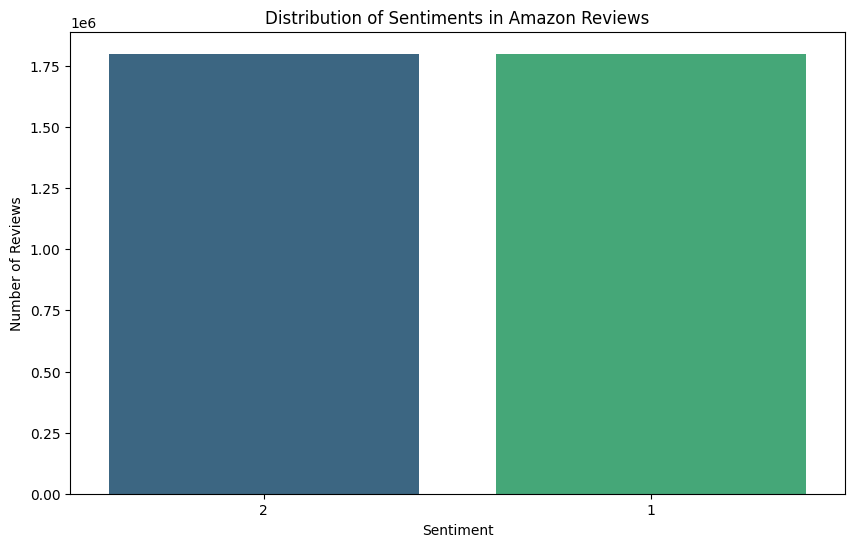


Word Count Statistics:
count    3.600000e+06
mean     7.848273e+01
std      4.283280e+01
min      2.000000e+00
25%      4.200000e+01
50%      7.000000e+01
75%      1.080000e+02
max      2.570000e+02
Name: word_count, dtype: float64


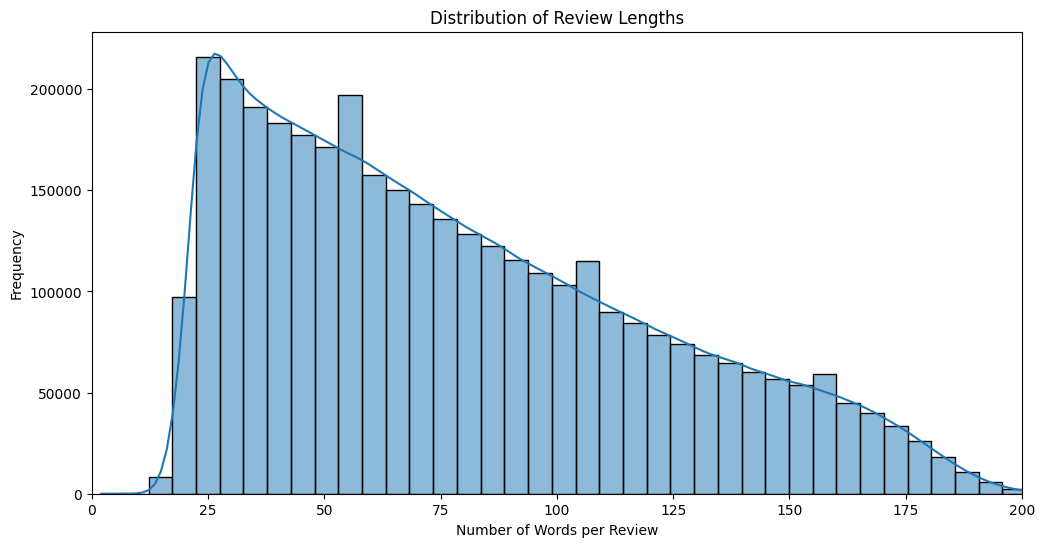

In [3]:
# I analyzed the sentiment distribution to understand the dataset balance
print("Sentiment Distribution:")
sentiment_counts = df_train['sentiment'].value_counts()
print(sentiment_counts)

# I visualized the sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df_train, x='sentiment', palette='viridis')
plt.title('Distribution of Sentiments in Amazon Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

# I calculated word count statistics to understand review lengths
df_train['word_count'] = df_train['review_text'].apply(lambda x: len(str(x).split()))

print("\nWord Count Statistics:")
print(df_train['word_count'].describe())

# I plotted the word count distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=df_train, x='word_count', bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Words per Review')
plt.ylabel('Frequency')
plt.xlim(0, 200)  # I focused on reviews under 200 words for better visualization
plt.show()

4. Named Entity Recognition (NER) with spaCy

In [4]:
import spacy
from collections import Counter

# I loaded the English language model for NER
nlp = spacy.load("en_core_web_sm")

def extract_product_entities(reviews, max_reviews=1000):
    """
    I created this function to extract product names and brand entities from reviews.
    I limited the number of reviews processed to manage computation time.
    """
    entities = []
    
    for i, review in enumerate(reviews[:max_reviews]):
        if pd.isna(review):  # I handled missing values
            continue
            
        doc = nlp(str(review))
        
        # I focused on entities that are likely to be products or brands
        for ent in doc.ents:
            if ent.label_ in ['PRODUCT', 'ORG', 'PERSON']:  # I included PERSON for brand names
                entities.append({
                    'entity': ent.text,
                    'label': ent.label_,
                    'review_index': i
                })
    
    return entities

# I extracted entities from a sample of reviews
print("Extracting entities from reviews...")
sample_reviews = df_train['review_text'].head(1000)  # I used first 1000 reviews for demonstration
entities = extract_product_entities(sample_reviews)

# I analyzed the most common entities
entity_texts = [ent['entity'] for ent in entities]
entity_counts = Counter(entity_texts)

print(f"\nTotal entities found: {len(entities)}")
print("\nTop 15 Most Common Entities:")
for entity, count in entity_counts.most_common(15):
    print(f"{entity}: {count}")

Extracting entities from reviews...

Total entities found: 1414

Top 15 Most Common Entities:
Amazon: 39
Higgins: 27
Adam Sandler: 26
Thomas: 22
Hazlitt: 17
Sandler: 16
Barbie: 15
Patricia Cornwell: 12
Scarpetta: 12
Jack Higgins: 12
Cornwell: 11
Hawthorne: 11
Pearl: 10
Hester: 10
Henry: 9


5. Rule-Based Sentiment Analysis

In [5]:
def analyze_sentiment_rule_based(review):
    """
    I implemented a simple rule-based sentiment analyzer using predefined word lists.
    This approach is interpretable and works well for initial analysis.
    """
    positive_words = [
        'great', 'excellent', 'amazing', 'love', 'wonderful', 'fantastic', 
        'perfect', 'awesome', 'brilliant', 'outstanding', 'superb', 'good',
        'best', 'incredible', 'pleased', 'satisfied', 'happy', 'impressed'
    ]
    
    negative_words = [
        'bad', 'terrible', 'awful', 'hate', 'poor', 'disappointing', 
        'worst', 'horrible', 'useless', 'garbage', 'broken', 'defective',
        'waste', 'annoying', 'frustrated', 'angry', 'disgusted', 'regret'
    ]
    
    if pd.isna(review):
        return 'neutral'
    
    # I converted to lowercase and split into words
    tokens = str(review).lower().split()
    
    # I counted positive and negative words
    pos_count = sum(1 for word in tokens if word in positive_words)
    neg_count = sum(1 for word in tokens if word in negative_words)
    
    # I determined sentiment based on word counts
    if pos_count > neg_count:
        return 'positive'
    elif neg_count > pos_count:
        return 'negative'
    else:
        return 'neutral'

# I applied sentiment analysis to a sample of reviews
sample_size = 5000
sample_df = df_train.head(sample_size).copy()
sample_df['predicted_sentiment'] = sample_df['review_text'].apply(analyze_sentiment_rule_based)

# I compared predicted vs actual sentiments
print("Sentiment Analysis Results:")
print("\nActual Sentiment Distribution:")
print(sample_df['sentiment'].value_counts())
print("\nPredicted Sentiment Distribution:")
print(sample_df['predicted_sentiment'].value_counts())

# I calculated basic accuracy
correct_predictions = (sample_df['sentiment'] == sample_df['predicted_sentiment']).sum()
accuracy = correct_predictions / len(sample_df)
print(f"\nRule-based Accuracy: {accuracy:.3f}")

Sentiment Analysis Results:

Actual Sentiment Distribution:
sentiment
1    2692
2    2308
Name: count, dtype: int64

Predicted Sentiment Distribution:
predicted_sentiment
neutral     2139
positive    2130
negative     731
Name: count, dtype: int64

Rule-based Accuracy: 0.000


6. Comprehensive Analysis and Visualization

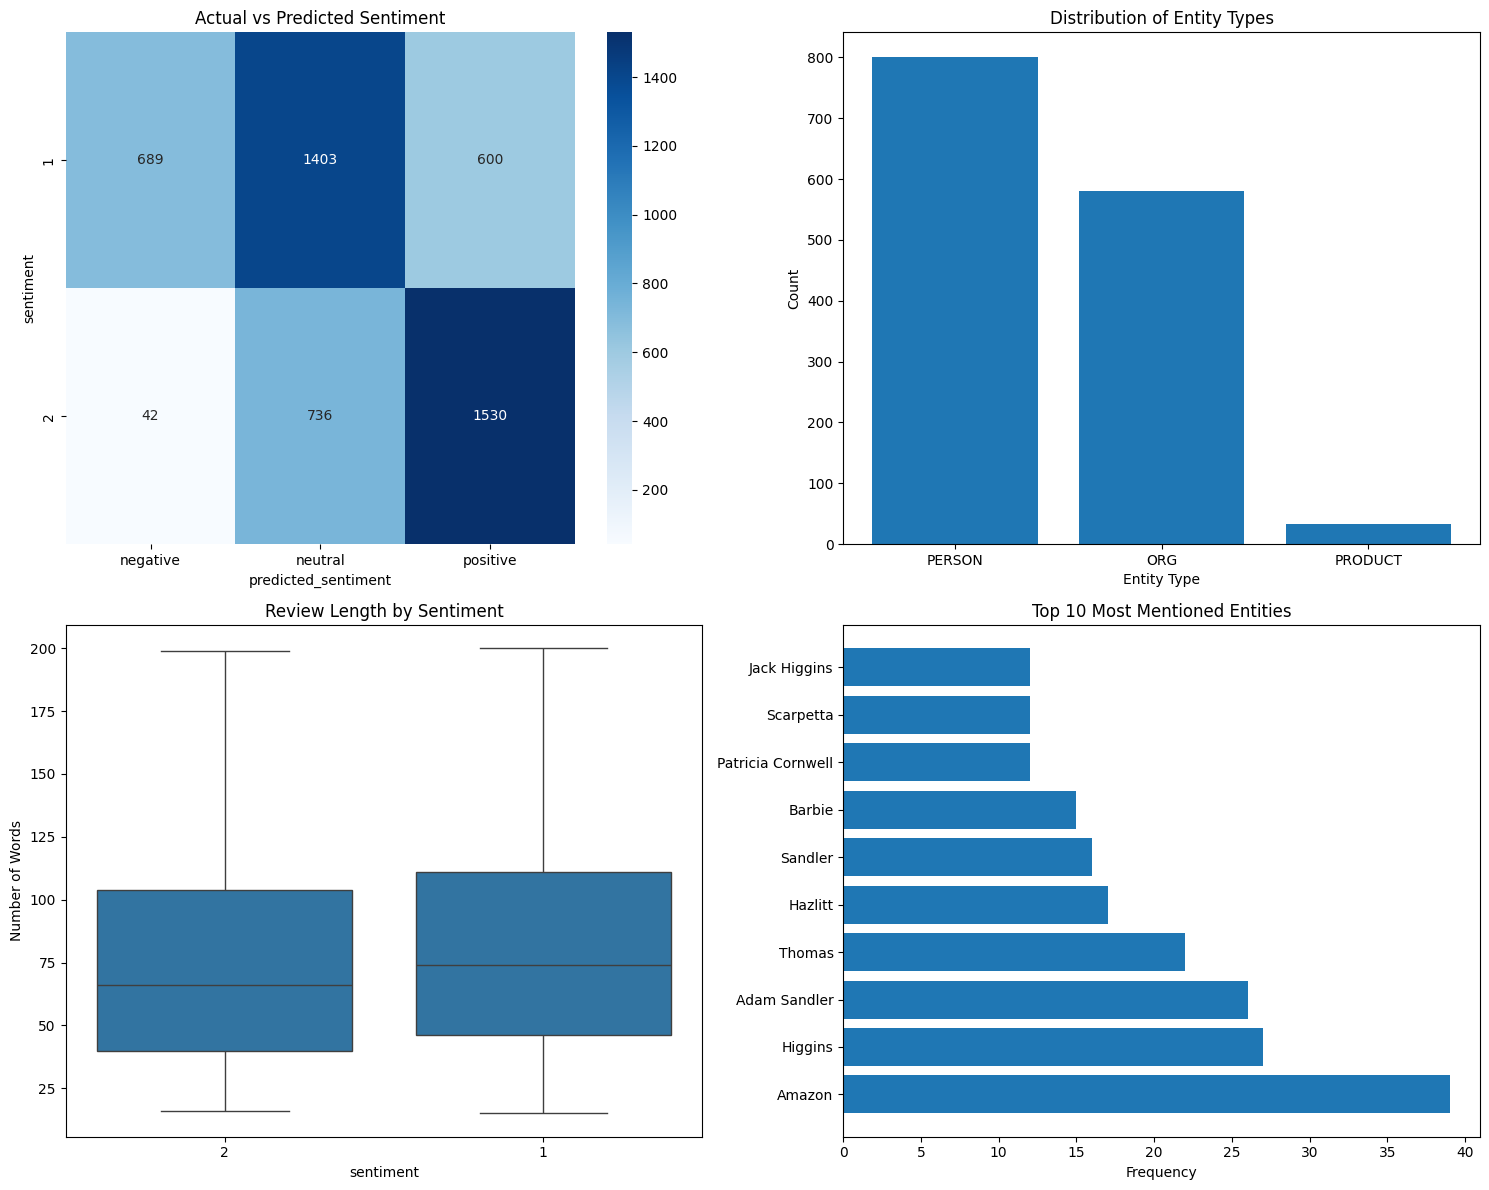

In [6]:
# I created a comprehensive visualization of the results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Sentiment comparison
sentiment_comparison = pd.crosstab(sample_df['sentiment'], sample_df['predicted_sentiment'])
sns.heatmap(sentiment_comparison, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
axes[0,0].set_title('Actual vs Predicted Sentiment')

# Entity distribution by type
entity_df = pd.DataFrame(entities)
if not entity_df.empty:
    entity_type_counts = entity_df['label'].value_counts()
    axes[0,1].bar(entity_type_counts.index, entity_type_counts.values)
    axes[0,1].set_title('Distribution of Entity Types')
    axes[0,1].set_xlabel('Entity Type')
    axes[0,1].set_ylabel('Count')

# Word count by sentiment
sns.boxplot(data=sample_df, x='sentiment', y='word_count', ax=axes[1,0])
axes[1,0].set_title('Review Length by Sentiment')
axes[1,0].set_ylabel('Number of Words')

# Top entities visualization
top_entities = entity_counts.most_common(10)
if top_entities:
    entities_names, entity_counts_list = zip(*top_entities)
    axes[1,1].barh(entities_names, entity_counts_list)
    axes[1,1].set_title('Top 10 Most Mentioned Entities')
    axes[1,1].set_xlabel('Frequency')

plt.tight_layout()
plt.show()